In [64]:
import os
import os, copy
import os.path
import subject2initial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks'))
    print(os.getcwd())
except:
    pass

strCurrentDirectory = os.getcwd()
print(strCurrentDirectory)

# "notebooks"ディレクトリよりも一階層上にいる場合はNotebooksフォルダに移動
if (strCurrentDirectory[-len("notebooks"):] != "notebooks") and (any("notebooks" in s for s in os.listdir())):
    os.chdir('notebooks')
    strCurrentDirectory = os.getcwd()
    print("notebooksフォルダの一階層上にいたのでnotebooksフォルダに移動しました。")

if strCurrentDirectory[-len("notebooks"):] == "notebooks":
    print("正常。作業ディレクトリがnotebooksフォルダに設定されています。")
else:
    print("エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリは" + strCurrentDirectory)

# %%
print(subject2initial.strInitialTest)


PATH_DATA_INT = subject2initial.funIsDirMakeDir(strPath="./data/interim")

C:\Users\SK250092\Desktop\Suzuki
エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリはC:\Users\SK250092\Desktop\Suzuki
イニシャルファイルからのテキスト読み込み
data\interim


## Data Loading

In [3]:
pddf = pd.read_csv("Wheel_data.csv")

# K-Means Clustring In Spark

K-means is one of the most commonly used clustering algorithms that clusters the data points into a predefined number of clusters. It is the simplest and popular unsupervised machine learning algorithms.

A cluster refers to a collection of data points aggregated together because of certain similarities. You will define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.

Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible. The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

### How the K-means algorithm works
To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids
It halts creating and optimizing clusters when either:
* The centroids have stabilized — there is no change in their values because the clustering has been successful.
* The defined number of iterations has been achieved.

### 1. Check Spark is installed on the machine

In [19]:
!java -version

java version "1.8.0_221"
Java(TM) SE Runtime Environment (build 1.8.0_221-b11)
Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)


### 2. Set up spark context and SparkSession

In [4]:
spark = SparkSession \
    .builder \
    .appName("Python Spark K-means example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
spark

### 3. Check the dataset

In [6]:
pddf = pddf[['FR', 'FL', 'RR', 'RL']]
# add a row index as a string
pddf['id'] = 'row'+pddf.index.astype(str)
#move it first (left)
cols = list(pddf)
cols.insert(0, cols.pop(cols.index('id')))
pddf = pddf.ix[:, cols]
pddf.head()

C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


,id,FR,FL,RR,RL
0,row0,0.0,0.0,0.0,0.0
1,row1,0.0,0.0,0.0,0.0
2,row2,0.0,0.0,0.0,0.0
3,row3,0.0,0.0,0.0,0.0
4,row4,0.0,0.0,0.0,0.0


### 4. SQL context
The SparkContext is created by default with the variable name sc with the way we started the spark enabled notebook. We do, however, want to create an SQLContext. According to the Spark documentation https://spark.apache.org/docs/latest/sql-programming-guide.html

"Spark SQL is a Spark module for structured data processing. Unlike the basic Spark RDD API, the interfaces provided by Spark SQL provide Spark with more information about the structure of both the data and the computation being performed."

What this means is that we can use Spark dataframes, which are similar to Pandas dataframes, and is a dataset organized into named columns.

In [7]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### 5. Create a Spark DataFrame from Pandas DataFrame

In [8]:
spark_df = spark.createDataFrame(pddf)

### 6. Convert all data columns to float
The machine learning model needs the data to be numbers so we must convert the features to floats. Here, our data points are already in float, however, the method to convert data into floats is shown below.

- Since we know which columns need to be converted, we get a cleaner result by converting those one by one.

In [9]:
FEATURES_COL = ['FR', 'FL', 'RR', 'RL']
for col in spark_df.columns:
    if col in FEATURES_COL:
        spark_df = spark_df.withColumn(col,spark_df[col].cast('float'))

### 7. Create a features column to be used in the clustering
Spark's implementation of KMeans is a bit different from for example scikit-learn's version. We need to store all features as an array of floats, and store this array as a column called "features".

In [10]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(spark_df).select('id', 'features')
df_kmeans.show()

+-----+---------+
|   id| features|
+-----+---------+
| row0|(4,[],[])|
| row1|(4,[],[])|
| row2|(4,[],[])|
| row3|(4,[],[])|
| row4|(4,[],[])|
| row5|(4,[],[])|
| row6|(4,[],[])|
| row7|(4,[],[])|
| row8|(4,[],[])|
| row9|(4,[],[])|
|row10|(4,[],[])|
|row11|(4,[],[])|
|row12|(4,[],[])|
|row13|(4,[],[])|
|row14|(4,[],[])|
|row15|(4,[],[])|
|row16|(4,[],[])|
|row17|(4,[],[])|
|row18|(4,[],[])|
|row19|(4,[],[])|
+-----+---------+
only showing top 20 rows



### 8. Train the machine learning model
We are now ready to train the model on the full dataset.
#### Assign clusters to events or features
Assigning the individual rows to the nearest cluster centroid can be done with the transform method, which adds 'prediction' column to the dataframe. The prediction value is an integer between 0 and k
#### Evaluate clustering by computing Silhouette score
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette score measures how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters. This measure has a range of :


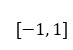

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). 
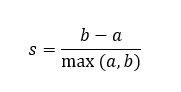

To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [11]:
#k=1
for k in range(2,6,1):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans)
    #assign clusters to events/features
    predictions = model.transform(df_kmeans).select('id', 'prediction', 'features')
    #rows = predictions.collect()
    #Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print ("For number of clusters" , k)
    print("The Silhouette with squared euclidean distance = " + str(silhouette))

For number of clusters 2
The Silhouette with squared euclidean distance = 0.8168933407346208
For number of clusters 3
The Silhouette with squared euclidean distance = 0.8511667012790562
For number of clusters 4
The Silhouette with squared euclidean distance = 0.8305344594731349
For number of clusters 5
The Silhouette with squared euclidean distance = 0.8035220437662665


### 9. Print the Centroids of the clusters
 - Once the training has converged we can print out the centroids of the clusters.

In [14]:
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
# This will print the Centroids of the best value of K clusters which is 3
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[4.56240323 4.56124662 4.52433394 4.50436993]
[-0.03168148 -0.02858671 -0.02837732 -0.02405086]
[-4.23377712 -4.26296844 -4.22825444 -4.25078896]


- From the rows returned by the collect method create a new dataframe using our SQL context. Join the prediction with the original data on the 'id' column

In [15]:
#assign clusters to events/features and join prediction with original data
predictions = model.transform(df_kmeans).select('id', 'prediction', 'features')
rows = predictions.collect()
df_pred = sqlContext.createDataFrame(rows)
#df_pred.show()
df_pred = df_pred.join(spark_df, 'id')
df_pred.show()

+-------+----------+--------------------+---------+------------+---------+---------+
|     id|prediction|            features|       FR|          FL|       RR|       RL|
+-------+----------+--------------------+---------+------------+---------+---------+
|row1093|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
|row1099|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
| row119|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
|row1191|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
|row1352|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
|row1586|         0|[2.95000004768371...|     2.95|       2.225|    2.725|     1.65|
|row1766|         1|           (4,[],[])|      0.0|         0.0|      0.0|      0.0|
|row2684|         1|[-1.625,-2.099999...|   -1.625|        -2.1|   -1.775|    -1.85|
|row2770|         0|[5.22499990463256...|    5.225|         7.1| 

### 10. Convert to Pandas dataframe

In [16]:
pddf_pred = df_pred.toPandas()
pddf_pred.head()

,id,prediction,features,FR,FL,RR,RL
0,row1093,1,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,0.0,0.0
1,row1099,1,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,0.0,0.0
2,row119,1,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,0.0,0.0
3,row1191,1,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,0.0,0.0
4,row1352,1,"(0.0, 0.0, 0.0, 0.0)",0.0,0.0,0.0,0.0


### 11. Shut down Spark Context
If done with Spark, we can now shut down the Spark context:

In [49]:
sc.stop()

# K-Means Clustring Example 2 Using SKlearn

### 1. Data Loading

In [31]:
df = pd.read_csv("data2.csv")

In [32]:
df.head()

,V1,V2
0,2.072345,-3.241693
1,17.936710,15.784810
2,1.083576,7.319176
3,11.120670,14.406780
4,23.711550,2.557729


### 2. Visualize the data points

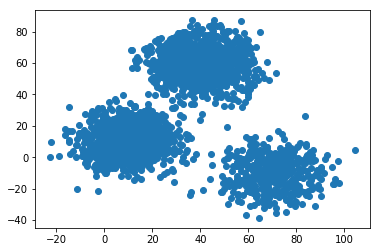

In [33]:
plt.scatter(df['V1'], df['V2'])

### 3. Train the model  
For model training specify the number of clusters. For this example, assign 2 clusters 

[[40.6609769  59.67801633]
 [31.2606333   3.19660767]]


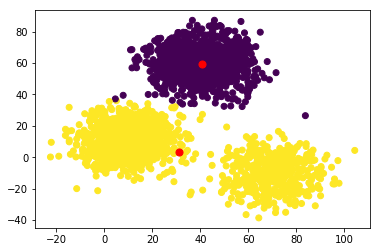

In [46]:
kmeans = KMeans(n_clusters=2).fit(df)
#find the center of each cluster
centroids = kmeans.cluster_centers_
print(centroids)
plt.scatter(df['V1'], df['V2'], c= kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

* Note that the center of each cluster (in red) represents the mean of all the observations that belong to that cluster.

* As you may also see, the observations that belong to a given cluster are closer to the center of that cluster, in comparison to the centers of other clusters.

### 4. Change the number of clusters

Let's change the n_clusters to 3 

[[69.89328381 -9.9292746 ]
 [40.68362784 59.71589274]
 [ 9.44867238 10.68248391]]


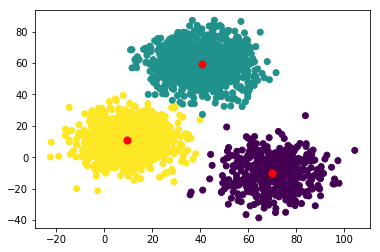

In [45]:
kmeans = KMeans(n_clusters=3).fit(df)
#find the center of each cluster
centroids = kmeans.cluster_centers_
print(centroids)
#visualize clusters and centroids
plt.scatter(df['V1'], df['V2'], c= kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

#### Change the n_clusters to 4

[[69.89328381 -9.9292746 ]
 [31.64816384 60.18672324]
 [ 9.42622151 10.65836421]
 [47.99395096 59.29070164]]


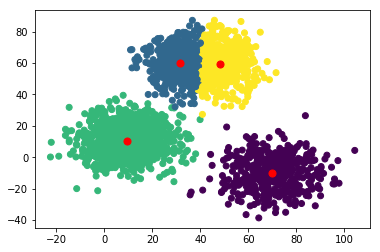

In [59]:
kmeans = KMeans(n_clusters=4).fit(df)
#find the center of each cluster
centroids = kmeans.cluster_centers_
print(centroids)
#plot the cluster and centroids
plt.scatter(df['V1'], df['V2'],c= kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

### 5. Predict the cluster of a data point

In [58]:
sample_test=np.array([100.0,-10.0])
second_test=sample_test.reshape(1, -1)
kmeans.predict(second_test)

array([2])

### 6. Evaluate the model (Elbow Method)
The “elbow” method helps to select the optimal number of clusters by fitting the model with a range of values for clusters. If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visualizer “elbow” will be annotated with a dashed line.

To demonstrate, in the following example the KElbowVisualizer fits the KMeans model for a range of cluster values from 2 to 10 on a sample two-dimensional dataset. When the model is fit, we can see a line annotating the “elbow” in the graph, which in this case we know to be the optimal number.

By default, the scoring parameter metric is set to distortion, which computes the sum of squared distances from each point to its assigned center.

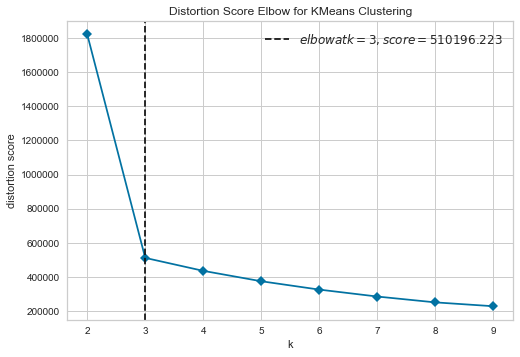

In [63]:
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False)
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data